In [3]:
!pip install -q openai
!pip install -q datasets==2.12.0

^C



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\GiaHyTran\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\GiaHyTran\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


Downloading dataset

In [1]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datasets import load_dataset

c:\Users\GiaHyTran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# API Key
api_key = ""

# Khởi tạo client 
client = OpenAI(api_key=api_key)

# Định nghĩa các model để so sánh
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]

### Hàm gọi API chung

In [25]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        messages = [{"role": "user", "content": prompt}]
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model}: {e}")
        return "ERROR"

def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0):
    """
    Hàm này nhận một chuỗi messages và tên model, trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model}: {e}")
        return "ERROR"

In [3]:
def calculate_metrics(actual, predicted, acceptable_classes):
    """
    Hàm này từ code gốc của bạn, dùng để tính toán và trả về các chỉ số.
    """
    # Lọc ra các cặp (dự đoán, thực tế) mà dự đoán nằm trong danh sách hợp lệ
    valid_pairs = [(act, pred) for act, pred in zip(actual, predicted) if pred in acceptable_classes]
    if not valid_pairs:
        return {'Accuracy': 0, 'F1 Score': 0, 'Precision': 0, 'Recall': 0}
        
    valid_actual = [pair[0] for pair in valid_pairs]
    valid_predicted = [pair[1] for pair in valid_pairs]

    accuracy = accuracy_score(valid_actual, valid_predicted)
    f1 = f1_score(valid_actual, valid_predicted, average='weighted', zero_division=0)
    precision = precision_score(valid_actual, valid_predicted, average='weighted', zero_division=0)
    recall = recall_score(valid_actual, valid_predicted, average='weighted', zero_division=0)
    
    return {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}

In [4]:
def create_demonstration_prompt(demonstration_df, label_map):
    """
    Hàm này tạo ra chuỗi ví dụ cho kịch bản few-shot.
    """
    result = ""
    for index, row in demonstration_df.iterrows():
        result += f"Utterance: {row['utt']}\nIntent: {label_map[row['intent']]}\n"
    return result

### Tải dữ liệu từ Hugging Face

In [50]:
# Tải và xử lý dữ liệu từ Hugging Face
print("Đang tải bộ dữ liệu MASSIVE...")
dataset = load_dataset("AmazonScience/massive")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Lọc ngôn ngữ Persian (fa-IR)
train_df_fa = train_df[train_df['locale'] == 'fa-IR'].copy()
test_df_fa = test_df[test_df['locale'] == 'fa-IR'].copy()

Đang tải bộ dữ liệu MASSIVE...


Using the latest cached version of the dataset since AmazonScience/massive couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'fa-IR' at C:\Users\GiaHyTran\.cache\huggingface\datasets\AmazonScience___massive\fa-IR\1.0.0\71d360eb7d7a18565ff8c10609cebf714fce3cc390e173ba5b02ffd48543cdc1 (last modified on Thu Jul 10 21:41:22 2025).


### Khám phá và phân thích dữ liệu (EDA)

In [ ]:
# Xem một vài mẫu
print(train_df_fa.sample(n=5, random_state=42))
print(test_df_fa.sample(n=5, random_state=42))

         id locale partition  scenario  intent  \
9710  14447  fa-IR     train        12      49   
8313  12365  fa-IR     train         1      42   
2960   4369  fa-IR     train         8      18   
3058   4507  fa-IR     train         3      45   
6933  10307  fa-IR     train         3      51   

                                                    utt  \
9710  میانگین درآمد سرانه بین مردم آسیا و اروپا چقدر...   
8313                   قطار از نکا چه ساعتی راه می افتد   
2960                                  به لامپ ها وصل شو   
3058                      آهنگ هایی مربوط به ابی پخش کن   
6933                                 با من چکرز بازی کن   

                                              annot_utt worker_id  \
9710  میانگین درآمد سرانه بین مردم [place_name : آسی...        21   
8313  [transport_type : قطار] از [place_name : نکا] ...        14   
2960                                  به لامپ ها وصل شو        17   
3058      آهنگ هایی مربوط به [artist_name : ابی] پخش کن         8   

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2974
    })
})

In [7]:
train = pd.DataFrame(dataset['train'])
train['intent']

0        48
1        48
2        46
3        46
4        46
         ..
11509    17
11510    44
11511    44
11512    44
11513    44
Name: intent, Length: 11514, dtype: int64

In [8]:
train = train[train['scenario'] == 3] #play subset
train['intent'].value_counts()

intent
45    639
36    283
58    193
20    150
51    112
Name: count, dtype: int64

In [9]:
train.head(100
           )

id locale partition  scenario  intent  \
22     34  fa-IR     train         3      45   
23     35  fa-IR     train         3      45   
43     66  fa-IR     train         3      45   
46     72  fa-IR     train         3      45   
47     73  fa-IR     train         3      45   
..    ...    ...       ...       ...     ...   
671   995  fa-IR     train         3      45   
672   996  fa-IR     train         3      45   
679  1005  fa-IR     train         3      45   
680  1006  fa-IR     train         3      45   
700  1034  fa-IR     train         3      45   

                                                   utt  \
22                من میخوام دوباره آهنگ ابی را گوش بدم   
23                من میخوام آن موزیک را دوباره پخش کنم   
43               لطفا خاطر خواه از ایوان بند را پخش کن   
46                            آهنگ از ایوان بند پخش کن   
47                       لطفا بهترین آهنگ من را پخش کن   
..                                                 ...   
671                           من میخوام ترس را گوش بدم   
672                آهنگ ترس را جستجو کن و آن را پخش کن   
679               از آخرین لیست آهنگ های من ابی پخش کن   
680  من میخوام آهنگ عشق را در لیست آهنگ های راک خود...   
700                                 آهنگ ابی را پخش کن   

                                             annot_utt worker_id  \
22   من میخوام دوباره آهنگ [artist_name : ابی] را گ...         3   
23   من میخوام آن [media_type : موزیک] را دوباره پخ...         3   
43   لطفا [song_name : خاطر خواه] از [artist_name :...         3   
46                            آهنگ از ایوان بند پخش کن         3   
47                       لطفا بهترین آهنگ من را پخش کن         3   
..                                                 ...       ...   
671             من میخوام [song_name : ترس] را گوش بدم         8   
672  آهنگ [song_name : ترس] را جستجو کن و آن را پخش کن         8   
679  از آخرین لیست آهنگ های من [artist_name : ابی] ...         8   
680  من میخوام آهنگ [artist_name : عشق] را در لیست ...         8   
700                 آهنگ [artist_name : ابی] را پخش کن         8   

                                           slot_method  \
22   {'slot': ['artist_name'], 'method': ['localiza...   
23   {'slot': ['media_type'], 'method': ['translati...   
43   {'slot': ['song_name', 'artist_name'], 'method...   
46                          {'slot': [], 'method': []}   
47                          {'slot': [], 'method': []}   
..                                                 ...   
671  {'slot': ['song_name'], 'method': ['localizati...   
672  {'slot': ['song_name'], 'method': ['localizati...   
679  {'slot': ['artist_name'], 'method': ['localiza...   
680  {'slot': ['artist_name', 'music_genre'], 'meth...   
700  {'slot': ['artist_name'], 'method': ['localiza...   

                                             judgments  
22   {'worker_id': ['21', '14', '8'], 'intent_score...  
23   {'worker_id': ['14', '3', '8'], 'intent_score'...  
43   {'worker_id': ['8', '9', '21'], 'intent_score'...  
46   {'worker_id': ['8', '21', '14'], 'intent_score...  
47   {'worker_id': ['8', '3', '14'], 'intent_score'...  
..                                                 ...  
671  {'worker_id': ['8', '21', '14'], 'intent_score...  
672  {'worker_id': ['14', '8', '21'], 'intent_score...  
679  {'worker_id': ['8', '21', '14'], 'intent_score...  
680  {'worker_id': ['8', '1', '14'], 'intent_score'...  
700  {'worker_id': ['14', '21', '8'], 'intent_score...  

[100 rows x 10 columns]

### Tiền xử lý dữ liệu (Preprossing)

In [10]:
# Chuyển thành DataFrame của Pandas
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
test_df['intent']

0       48
1       46
2        1
3       41
4       40
        ..
2969    33
2970    44
2971    44
2972    44
2973    44
Name: intent, Length: 2974, dtype: int64

In [11]:
test_df.head()

id locale partition  scenario  intent                                 utt  \
0   0  fa-IR      test        16      48     این هفته ساعت پنج صبح بیدارم کن   
1   3  fa-IR      test        10      46                                ساکت   
2   8  fa-IR      test         8       1   صورتی همان چیزی است که نیاز داریم   
3  14  fa-IR      test         8      41                     و تاریک شده است   
4  19  fa-IR      test         8      40  علی چراغ‌های اتاق خواب را خاموش کن   

                                           annot_utt worker_id  \
0  [date : این هفته] ساعت [time : پنج صبح] بیدارم کن         8   
1                                               ساکت        17   
2   [color_type : صورتی] همان چیزی است که نیاز داریم         3   
3                                    و تاریک شده است         5   
4  علی چراغ‌های [house_place : اتاق] خواب را خامو...         3   

                                         slot_method  \
0  {'slot': ['time', 'date'], 'method': ['transla...   
1                         {'slot': [], 'method': []}   
2  {'slot': ['color_type'], 'method': ['translati...   
3                         {'slot': [], 'method': []}   
4  {'slot': ['house_place'], 'method': ['translat...   

                                           judgments  
0  {'worker_id': ['3', '21', '8'], 'intent_score'...  
1  {'worker_id': ['3', '8', '21'], 'intent_score'...  
2  {'worker_id': ['3', '21', '8'], 'intent_score'...  
3  {'worker_id': ['21', '14', '3'], 'intent_score...  
4  {'worker_id': ['8', '14', '3'], 'intent_score'...

In [12]:
for i in range(18):
    print(i)
    print(len(test_df[test_df['scenario'] == i]))
    print(test_df[test_df['scenario'] == i]['intent'].value_counts())
    print('-----------------------------------------------------------')

0
106
intent
47    81
27    25
Name: count, dtype: int64
-----------------------------------------------------------
1
124
intent
42    51
2     35
54    23
11    15
Name: count, dtype: int64
-----------------------------------------------------------
2
402
intent
50    209
32    126
30     67
Name: count, dtype: int64
-----------------------------------------------------------
3
387
intent
45    176
36     72
58     63
20     41
51     35
Name: count, dtype: int64
-----------------------------------------------------------
4
124
intent
22    124
Name: count, dtype: int64
-----------------------------------------------------------
5
103
intent
0     88
38    15
Name: count, dtype: int64
-----------------------------------------------------------
6
94
intent
6     43
19    31
55    20
Name: count, dtype: int64
-----------------------------------------------------------
7
271
intent
44    119
33    114
17     26
15     12
Name: count, dtype: int64
----------------------------------------

In [13]:
# Lọc ra tập con "play" (scenario == 3) như trong notebook gốc
train_data = train_df_fa[train_df_fa['scenario'] == 3].copy()
test_data_full = test_df_fa[test_df_fa['scenario'] == 3].copy()
test_data_full['intent'].value_counts()

intent
45    176
36     72
58     63
20     41
51     35
Name: count, dtype: int64

In [14]:
n_test_sample = 1
test_prompt = test_data_full.groupby('intent').apply(lambda x: x.sample(n_test_sample))

test_prompt.head()

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_20748\3286241878.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_prompt = test_data_full.groupby('intent').apply(lambda x: x.sample(n_test_sample))


id locale partition  scenario  intent  \
intent                                                  
20     1689   9760  fa-IR      test         3      20   
36     1609   9284  fa-IR      test         3      36   
45     531    3146  fa-IR      test         3      45   
51     1815  10399  fa-IR      test         3      51   
58     2001  11437  fa-IR      test         3      58   

                                                   utt  \
intent                                                   
20     1689                            پخش را متوقف کن   
36     1609                     موج اف. ام. را روشن کن   
45     531     قطعه اول از لیست آهنگ های ابی من پخش کن   
51     1815  لطفا بازی شطرنج را باز کن و با من بازی کن   
58     2001              لطفا فایل صوتی برای من پخش کن   

                                                     annot_utt worker_id  \
intent                                                                     
20     1689                 پخش را [player_setting : متوقف کن]         3   
36     1609                             موج اف. ام. را روشن کن         8   
45     531   قطعه اول از لیست آهنگ های [artist_name : ابی] ...         8   
51     1815  لطفا بازی [game_name : شطرنج] را باز کن و با م...         3   
58     2001                      لطفا فایل صوتی برای من پخش کن         3   

                                                   slot_method  \
intent                                                           
20     1689  {'slot': ['player_setting'], 'method': ['trans...   
36     1609                         {'slot': [], 'method': []}   
45     531   {'slot': ['artist_name'], 'method': ['localiza...   
51     1815  {'slot': ['game_name'], 'method': ['translatio...   
58     2001                         {'slot': [], 'method': []}   

                                                     judgments  
intent                                                          
20     1689  {'worker_id': ['8', '14', '21'], 'intent_score...  
36     1609  {'worker_id': ['14', '21', '8'], 'intent_score...  
45     531   {'worker_id': ['21', '14', '8'], 'intent_score...  
51     1815  {'worker_id': ['14', '8', '1'], 'intent_score'...  
58     2001  {'worker_id': ['9', '3', '8'], 'intent_score':...

In [15]:
# === Lấy 10 mẫu để kiểm tra ===
SAMPLE_SIZE = 387 
test_data = test_data_full.sample(n=SAMPLE_SIZE, random_state=42)

print(f"✅ Đã tải và xử lý {len(test_data_full)} dữ liệu thành công.")
print(f"   -> Sử dụng {len(test_data)} mẫu để kiểm tra.")

✅ Đã tải và xử lý 387 dữ liệu thành công.
   -> Sử dụng 387 mẫu để kiểm tra.


In [16]:
# Tạo các mẫu cho Few-shot prompting
n_sample_each_group = 3
demonstration = train.groupby('intent').apply(lambda x: x.sample(n_sample_each_group, random_state=42)).reset_index(drop=True)
demonstration = demonstration.sample(frac=1, random_state=42).reset_index(drop=True)

demonstration.head()

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_20748\1098398067.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demonstration = train.groupby('intent').apply(lambda x: x.sample(n_sample_each_group, random_state=42)).reset_index(drop=True)


id locale partition  scenario  intent  \
0  10314  fa-IR     train         3      51   
1  10251  fa-IR     train         3      51   
2   9785  fa-IR     train         3      20   
3  11475  fa-IR     train         3      58   
4   9412  fa-IR     train         3      36   

                                  utt  \
0  بیا با هم space invaders بازی کنیم   
1                    فلپی برد بازی کن   
2                      کتاب را باز کن   
3            فایل صوتی بعدی را پخش کن   
4         من میخوام رادیو راه گوش بدم   

                                          annot_utt worker_id  \
0  بیا با هم [game_name : space invaders] بازی کنیم         8   
1                    [game_name : فلپی برد] بازی کن        14   
2                 کتاب را [player_setting : باز کن]         3   
3   [podcast_descriptor : فایل صوتی بعدی] را پخش کن         3   
4        من میخوام [radio_name : رادیو راه] گوش بدم         8   

                                         slot_method  \
0   {'slot': ['game_name'], 'method': ['unchanged']}   
1   {'slot': ['game_name'], 'method': ['unchanged']}   
2  {'slot': ['player_setting'], 'method': ['trans...   
3  {'slot': ['podcast_descriptor'], 'method': ['t...   
4  {'slot': ['radio_name'], 'method': ['localizat...   

                                           judgments  
0  {'worker_id': ['8', '21', '14'], 'intent_score...  
1  {'worker_id': ['14', '8', '3'], 'intent_score'...  
2  {'worker_id': ['8', '21', '14'], 'intent_score...  
3  {'worker_id': ['14', '8', '21'], 'intent_score...  
4  {'worker_id': ['14', '21', '8'], 'intent_score...

In [17]:
# Tạo các mẫu cho Few-shot prompting (lấy 3 ví dụ cho mỗi loại ý định)
demonstration_df = train_data.groupby('intent').apply(lambda x: x.sample(min(len(x), 3), random_state=42)).reset_index(drop=True)

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_20748\133025308.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  demonstration_df = train_data.groupby('intent').apply(lambda x: x.sample(min(len(x), 3), random_state=42)).reset_index(drop=True)


In [18]:
# Định nghĩa các bản đồ nhãn và danh sách nhãn
intent_map_en = {45: 'play_music', 36: 'play_radio', 58:'play_podcasts', 20:'play_audiobook', 51:'play_game'}
acceptable_classes_en = list(intent_map_en.values())

intent_map_fa = {45: 'پخش_موسیقی', 36: 'پخش_رادیو', 58:'پخش_پادکست', 20:'پخش_کتاب_صوتی', 51:'بازی_کردن'}
acceptable_classes_fa = list(intent_map_fa.values())

In [19]:
# Tạo các chuỗi ví dụ cho kịch bản few-shot
demonstration_text_en = create_demonstration_prompt(demonstration_df, intent_map_en)
demonstration_text_fa = create_demonstration_prompt(demonstration_df, intent_map_fa)

### Zero-shot

In [20]:
max_retries = 5

### ZERO_SHOT

In [28]:
prompt = f"""
The below sentence is a person's utterance to a virtual assistant. The utterance is in Persian. Identify the intent associated with it. \
Possible answers are: play_music, play_radio, play_podcasts, play_audiobook, play_game. (Please only reply one of these and nothing else!) \

utterance: SAMPLE
intent:
"""

In [29]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_en[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")

utterance: پخش را متوقف کن
Model Response: play_music
Actual Label: play_audiobook
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: play_radio
Actual Label: play_radio
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: play_music
Actual Label: play_music
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: play_game
Actual Label: play_game
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: play_audiobook
Actual Label: play_podcasts
---------------------------------------------------------------------


In [30]:
prompt = f"""
جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن.
پاسخ های ممکن عبارتند از: play_music, play_radio, play_podcasts, play_audiobook, play_game. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!) \

جمله: SAMPLE
نیت:
"""


In [31]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_en[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")


utterance: پخش را متوقف کن
Model Response: stop_playing_music
Actual Label: play_audiobook
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: play_radio
Actual Label: play_radio
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: play_music
Actual Label: play_music
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: play_game
Actual Label: play_game
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: play_audiobook
Actual Label: play_podcasts
---------------------------------------------------------------------


In [32]:
prompt = f"""
جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن.
پاسخ های ممکن عبارتند از: پخش_موسیقی, پخش_رادیو, پخش_پادکست, پخش_کتاب_صوتی, بازی_کردن. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!) \

جمله: SAMPLE
نیت:
"""

In [33]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_fa[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")


utterance: پخش را متوقف کن
Model Response: پخش موسیقی
Actual Label: پخش_کتاب_صوتی
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: پخش_رادیو
Actual Label: پخش_رادیو
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: پخش_موسیقی
Actual Label: پخش_موسیقی
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: بازی_کردن
Actual Label: بازی_کردن
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: پخش_کتاب_صوتی
Actual Label: پخش_پادکست
---------------------------------------------------------------------


### Few-shot

In [34]:
print(create_demonstration_prompt(demonstration, label_map=intent_map_en))

Utterance: بیا با هم space invaders بازی کنیم
Intent: play_game
Utterance: فلپی برد بازی کن
Intent: play_game
Utterance: کتاب را باز کن
Intent: play_audiobook
Utterance: فایل صوتی بعدی را پخش کن
Intent: play_podcasts
Utterance: من میخوام رادیو راه گوش بدم
Intent: play_radio
Utterance: الکسا میتونی آهنگ مورد علاقه من را پخش کنی
Intent: play_music
Utterance: audible را باز کن و به پخش کتابی که من داشتم گوش میدادم ادامه بده
Intent: play_audiobook
Utterance: ادامه ی کتاب صوتی تاریخ روم رو پخش کن
Intent: play_audiobook
Utterance: در ستایش ترس قسمت بیست و سوم را پخش کن
Intent: play_podcasts
Utterance: ازت میخوام که رادیو را روشن کنی
Intent: play_radio
Utterance: لطفا آهنگ هایی از ایوان بند پخش کن
Intent: play_music
Utterance: بازی را اجرا کن
Intent: play_game
Utterance: قسمت بعدی مونولوگ را پخش کن
Intent: play_podcasts
Utterance: رادیو olly رو روشن کن
Intent: play_radio
Utterance: از آرتیست مشخص موزیک پخش کن
Intent: play_music



In [35]:
few_shot_prompt_en_en = f"""
The below sentence is a person's utterance to a virtual assistant. The utterance is in Persian. Identify the intent associated with it. \
Possible answers are: play_music, play_radio, play_podcasts, play_audiobook, play_game. (Please only reply one of these and nothing else!) \

Examples:
{demonstration_text_en}

utterance: SAMPLE
intent:
"""

In [36]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            # print(prompt.replace("SAMPLE", row['utt']), response)
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_en[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")

utterance: پخش را متوقف کن
Model Response: پخش موسیقی
Actual Label: play_audiobook
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: پخش_رادیو
Actual Label: play_radio
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: پخش_موسیقی
Actual Label: play_music
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: بازی_کردن
Actual Label: play_game
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: پخش_کتاب_صوتی
Actual Label: play_podcasts
---------------------------------------------------------------------


In [37]:
few_shot_prompt_fa_en = f"""
جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن.
پاسخ های ممکن عبارتند از: play_music, play_radio, play_podcasts, play_audiobook, play_game. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!) \

مثالها:
{demonstration_text_en}

جمله: SAMPLE
نیت:
"""


In [38]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            # print(prompt.replace("SAMPLE", row['utt']), response)
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_en[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")

utterance: پخش را متوقف کن
Model Response: پخش_موسیقی
Actual Label: play_audiobook
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: پخش_رادیو
Actual Label: play_radio
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: پخش_موسیقی
Actual Label: play_music
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: بازی_کردن
Actual Label: play_game
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: پخش_کتاب_صوتی
Actual Label: play_podcasts
---------------------------------------------------------------------


In [39]:
few_shot_prompt_fa_fa = f"""
جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن.
پاسخ های ممکن عبارتند از: پخش_موسیقی, پخش_رادیو, پخش_پادکست, پخش_کتاب_صوتی, بازی_کردن. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!) \

مثالها:
{create_demonstration_prompt(demonstration, label_map=intent_map_fa)}

جمله: SAMPLE
نیت:
"""

In [40]:
for index, row in test_prompt.iterrows():
    retries = 0
    while retries < max_retries:
        try:
            response = get_completion(prompt.replace("SAMPLE", row['utt']))
            # print(prompt.replace("SAMPLE", row['utt']), response)
            print(f"utterance: {row['utt']}")
            print(f"Model Response: {response}")
            print(f"Actual Label: {intent_map_fa[row['intent']]}")
            print("---------------------------------------------------------------------")
            break
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            retries += 1
            print(f"Retrying ({retries}/{max_retries})...")
            time.sleep(30)

    if retries == max_retries:
        print(f"Failed to process sample after {max_retries} retries. Skipping to the next sample.")

utterance: پخش را متوقف کن
Model Response: پخش موسیقی
Actual Label: پخش_کتاب_صوتی
---------------------------------------------------------------------
utterance: موج اف. ام. را روشن کن
Model Response: پخش_رادیو
Actual Label: پخش_رادیو
---------------------------------------------------------------------
utterance: قطعه اول از لیست آهنگ های ابی من پخش کن
Model Response: پخش_موسیقی
Actual Label: پخش_موسیقی
---------------------------------------------------------------------
utterance: لطفا بازی شطرنج را باز کن و با من بازی کن
Model Response: بازی_کردن
Actual Label: بازی_کردن
---------------------------------------------------------------------
utterance: لطفا فایل صوتی برای من پخش کن
Model Response: پخش_کتاب_صوتی
Actual Label: پخش_پادکست
---------------------------------------------------------------------


### So sánh kết quả của 2 model "GPT-3.5-turbo" và "GPT-4o-mini"

In [21]:
PROMPT_TEMPLATES = {
    "zero_shot_en_en": """The below sentence is a person's utterance to a virtual assistant. The utterance is in Persian. Identify the intent associated with it. Possible answers are: play_music, play_radio, play_podcasts, play_audiobook, play_game. (Please only reply one of these and nothing else!)\n\nutterance: {utt}\nintent:""",
    "zero_shot_fa_en": """جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن. پاسخ های ممکن عبارتند از: play_music, play_radio, play_podcasts, play_audiobook, play_game. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!)\n\nجمله: {utt}\nنیت:""",
    "zero_shot_fa_fa": """جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن. پاسخ های ممکن عبارتند از: پخش_موسیقی, پخش_رادیو, پخش_پادکست, پخش_کتاب_صوتی, بازی_کردن. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!)\n\nجمله: {utt}\nنیت:""",
    "few_shot_en_en": f"""The below sentence is a person's utterance to a virtual assistant. The utterance is in Persian. Identify the intent associated with it. Possible answers are: play_music, play_radio, play_podcasts, play_audiobook, play_game. (Please only reply one of these and nothing else!)\n\nExamples:\n{demonstration_text_en}\nutterance: {{utt}}\nintent:""",
    "few_shot_fa_en": f"""جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن. پاسخ های ممکن عبارتند از: play_music, play_radio, play_podcasts, play_audiobook, play_game. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!)\n\nمثالها:\n{demonstration_text_en}\nجمله: {{utt}}\nنیت:""",
    "few_shot_fa_fa": f"""جمله زیر صحبت یک فرد با یک دستیار مجازی است. هدف (نیت) مرتبط با هر جمله را تعیین کن. پاسخ های ممکن عبارتند از: پخش_موسیقی, پخش_رادیو, پخش_پادکست, پخش_کتاب_صوتی, بازی_کردن. (لطفاً فقط یکی از این موارد را پاسخ بده و نه چیز دیگری!)\n\nمثالها:\n{demonstration_text_fa}\nجمله: {{utt}}\nنیت:"""
}

In [26]:
# Định nghĩa các kịch bản thực nghiệm
experiments = [
    ("Zero-shot", "EN Prompt / EN Labels", PROMPT_TEMPLATES["zero_shot_en_en"], intent_map_en, acceptable_classes_en),
    ("Zero-shot", "FA Prompt / EN Labels", PROMPT_TEMPLATES["zero_shot_fa_en"], intent_map_en, acceptable_classes_en),
    ("Zero-shot", "FA Prompt / FA Labels", PROMPT_TEMPLATES["zero_shot_fa_fa"], intent_map_fa, acceptable_classes_fa),
    ("Few-shot",  "EN Prompt / EN Labels", PROMPT_TEMPLATES["few_shot_en_en"], intent_map_en, acceptable_classes_en),
    ("Few-shot",  "FA Prompt / EN Labels", PROMPT_TEMPLATES["few_shot_fa_en"], intent_map_en, acceptable_classes_en),
    ("Few-shot",  "FA Prompt / FA Labels", PROMPT_TEMPLATES["few_shot_fa_fa"], intent_map_fa, acceptable_classes_fa)
]

# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn để duyệt qua từng model
for model_name in MODELS_TO_COMPARE:
    print(f"\n{'='*30}\n BẮT ĐẦU MODEL: {model_name} \n{'='*30}")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt đã định nghĩa
    for exp_type, description, prompt_template, current_map, current_classes in experiments:
        exp_name = f"{exp_type} - {description}"
        print(f"--- Đang chạy kịch bản: {exp_name} ---")

        actual_labels = []
        predicted_labels = []

        # Vòng lặp trong cùng: chạy qua từng mẫu dữ liệu thử nghiệm
        for index, row in tqdm(test_data.iterrows(), total=len(test_data), desc=f"Querying {exp_name}"):
            actual_label = current_map.get(row['intent'])
            
            if actual_label:
                # Tạo prompt hoàn chỉnh bằng cách điền dữ liệu vào mẫu
                prompt = prompt_template.format(utt=row['utt'])
                
                # Gọi hàm và chỉ định rõ model cần dùng
                response = get_completion(prompt, model=model_name)
                
                # Lưu lại đáp án đúng và câu trả lời của model
                actual_labels.append(actual_label)
                predicted_labels.append(response.strip().split('\n')[0])
                time.sleep(1) # Chờ 1 giây để tránh bị giới hạn API

        # Lưu lại kết quả của toàn bộ kịch bản này
        final_results[model_name][exp_name] = {
            "actual": actual_labels,
            "predicted": predicted_labels,
            "acceptable_classes": current_classes
        }
        print(f"--- Hoàn thành thu thập dữ liệu cho kịch bản: {exp_name} ---\n")

print("Đã hoàn thành tất cả các thử nghiệm.")


 BẮT ĐẦU MODEL: gpt-3.5-turbo 
--- Đang chạy kịch bản: Zero-shot - EN Prompt / EN Labels ---


Querying Zero-shot - EN Prompt / EN Labels: 100%|██████████| 387/387 [10:17<00:00,  1.59s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - EN Prompt / EN Labels ---

--- Đang chạy kịch bản: Zero-shot - FA Prompt / EN Labels ---


Querying Zero-shot - FA Prompt / EN Labels: 100%|██████████| 387/387 [10:28<00:00,  1.62s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - FA Prompt / EN Labels ---

--- Đang chạy kịch bản: Zero-shot - FA Prompt / FA Labels ---


Querying Zero-shot - FA Prompt / FA Labels: 100%|██████████| 387/387 [10:47<00:00,  1.67s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - FA Prompt / FA Labels ---

--- Đang chạy kịch bản: Few-shot - EN Prompt / EN Labels ---


Querying Few-shot - EN Prompt / EN Labels: 100%|██████████| 387/387 [10:15<00:00,  1.59s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - EN Prompt / EN Labels ---

--- Đang chạy kịch bản: Few-shot - FA Prompt / EN Labels ---


Querying Few-shot - FA Prompt / EN Labels: 100%|██████████| 387/387 [10:29<00:00,  1.63s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - FA Prompt / EN Labels ---

--- Đang chạy kịch bản: Few-shot - FA Prompt / FA Labels ---


Querying Few-shot - FA Prompt / FA Labels: 100%|██████████| 387/387 [11:02<00:00,  1.71s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - FA Prompt / FA Labels ---


 BẮT ĐẦU MODEL: gpt-4o-mini 
--- Đang chạy kịch bản: Zero-shot - EN Prompt / EN Labels ---


Querying Zero-shot - EN Prompt / EN Labels: 100%|██████████| 387/387 [10:46<00:00,  1.67s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - EN Prompt / EN Labels ---

--- Đang chạy kịch bản: Zero-shot - FA Prompt / EN Labels ---


Querying Zero-shot - FA Prompt / EN Labels: 100%|██████████| 387/387 [11:06<00:00,  1.72s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - FA Prompt / EN Labels ---

--- Đang chạy kịch bản: Zero-shot - FA Prompt / FA Labels ---


Querying Zero-shot - FA Prompt / FA Labels: 100%|██████████| 387/387 [11:34<00:00,  1.80s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Zero-shot - FA Prompt / FA Labels ---

--- Đang chạy kịch bản: Few-shot - EN Prompt / EN Labels ---


Querying Few-shot - EN Prompt / EN Labels: 100%|██████████| 387/387 [10:29<00:00,  1.63s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - EN Prompt / EN Labels ---

--- Đang chạy kịch bản: Few-shot - FA Prompt / EN Labels ---


Querying Few-shot - FA Prompt / EN Labels: 100%|██████████| 387/387 [11:33<00:00,  1.79s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - FA Prompt / EN Labels ---

--- Đang chạy kịch bản: Few-shot - FA Prompt / FA Labels ---


Querying Few-shot - FA Prompt / FA Labels: 100%|██████████| 387/387 [11:52<00:00,  1.84s/it]

--- Hoàn thành thu thập dữ liệu cho kịch bản: Few-shot - FA Prompt / FA Labels ---

Đã hoàn thành tất cả các thử nghiệm.


In [61]:
# DataFrame để lưu trữ các chỉ số
evaluation_results = []

def post_process_predictions(predictions, acceptable_classes):
    """Chuẩn hóa và lọc các dự đoán không hợp lệ."""
    processed = []
    for pred in predictions:
        # Tìm xem có nhãn nào hợp lệ trong câu trả lời không
        found = False
        for label in acceptable_classes:
            if label in pred:
                processed.append(label)
                found = True
                break
        if not found:
            processed.append("ERROR") # Gán nhãn lỗi nếu không tìm thấy
    return processed

# Vòng lặp qua kết quả của từng model để tính toán
for model_name, prompt_results in final_results.items():
    for exp_name, results in prompt_results.items():
        # Gọi hàm calculate_metrics từ code gốc của bạn để tính toán
        metrics = calculate_metrics(results['actual'], results['predicted'], results['acceptable_classes'])
        
        evaluation_results.append({
            "Model": model_name,
            "Kịch bản": exp_name,
            "Accuracy": f"{metrics['Accuracy']*100:.2f}%",
            "F1-Score": f"{metrics['F1 Score']*100:.2f}%"
        })

# Tạo và in bảng so sánh cuối cùng
summary_df = pd.DataFrame(evaluation_results)
pivot_df = summary_df.pivot_table(index="Kịch bản", columns="Model", values=["Accuracy", "F1-Score"], aggfunc='first')

print("\n\n📊=============== BẢNG SO SÁNH HIỆU NĂNG PHÂN LOẠI Ý ĐỊNH ===============📊")
print(pivot_df.to_markdown())



📊=============== BẢNG SO SÁNH HIỆU NĂNG PHÂN LOẠI Ý ĐỊNH ===============📊
| Kịch bản                          | ('Accuracy', 'gpt-3.5-turbo')   | ('Accuracy', 'gpt-4o-mini')   | ('F1-Score', 'gpt-3.5-turbo')   | ('F1-Score', 'gpt-4o-mini')   |
|:----------------------------------|:--------------------------------|:------------------------------|:--------------------------------|:------------------------------|
| Few-shot - EN Prompt / EN Labels  | 88.54%                          | 88.89%                        | 88.50%                          | 88.73%                        |
| Few-shot - FA Prompt / EN Labels  | 86.75%                          | 87.21%                        | 86.77%                          | 87.01%                        |
| Few-shot - FA Prompt / FA Labels  | 83.85%                          | 87.53%                        | 83.83%                          | 87.39%                        |
| Zero-shot - EN Prompt / EN Labels | 79.53%                          | 80



📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH ===============📈


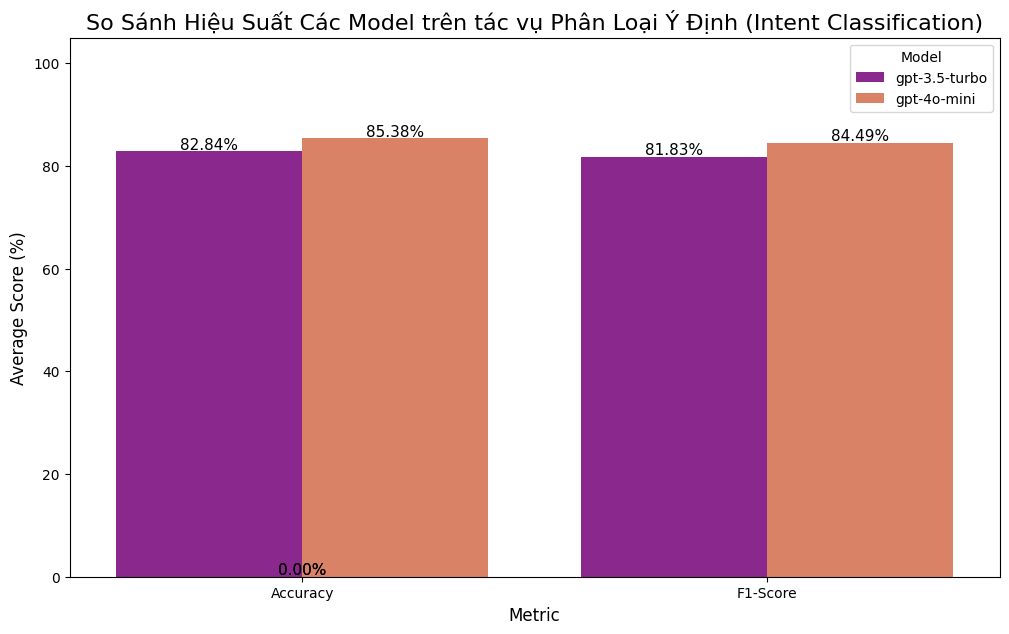



📊=============== BẢNG TÓM TẮT HIỆU SUẤT TRUNG BÌNH ===============📊
| Model         |   Accuracy |   F1-Score |
|:--------------|-----------:|-----------:|
| gpt-3.5-turbo |      82.84 |      81.83 |
| gpt-4o-mini   |      85.38 |      84.49 |


In [68]:
data = {
    'Experiment': [
        'Few-shot - EN Prompt / EN Labels', 'Few-shot - FA Prompt / EN Labels', 'Few-shot - FA Prompt / FA Labels',
        'Zero-shot - EN Prompt / EN Labels', 'Zero-shot - FA Prompt / EN Labels', 'Zero-shot - FA Prompt / FA Labels'
    ] * 2, # Sửa ở đây: Lặp lại danh sách kịch bản 2 lần
    'Model': [
        'gpt-3.5-turbo'] * 6 + ['gpt-4o-mini'] * 6, # Lặp lại tên model 6 lần cho mỗi loại
    'Accuracy': [
        88.54, 86.75, 83.85, 79.53, 81.41, 76.97,  # Điểm của gpt-3.5-turbo
        88.89, 87.21, 87.53, 80.31, 84.68, 83.68   # Điểm của gpt-4o-mini
    ],
    'F1-Score': [
        88.50, 86.77, 83.83, 77.42, 80.44, 74.02,  # Điểm của gpt-3.5-turbo
        88.73, 87.01, 87.39, 77.57, 83.74, 82.49   # Điểm của gpt-4o-mini
    ]
}

df_detailed = pd.DataFrame(data)

print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH ===============📈")

# Nhóm theo model và tính điểm trung bình cho từng chỉ số
df_summary = df_detailed.groupby('Model')[['Accuracy', 'F1-Score']].mean().reset_index()

# Chuẩn bị dữ liệu để vẽ
df_summary_melted = df_summary.melt(id_vars='Model', var_name='Metric', value_name='Average Score')

# Vẽ biểu đồ
plt.figure(figsize=(12, 7))
sns.barplot(x='Metric', y='Average Score', hue='Model', data=df_summary_melted, palette='plasma')

# Tùy chỉnh biểu đồ (bằng tiếng Anh)
plt.title('So Sánh Hiệu Suất Các Model trên tác vụ Phân Loại Ý Định (Intent Classification)', fontsize=16)
plt.ylabel('Average Score (%)', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 105) # Tăng giới hạn trục y để hiển thị số rõ hơn
plt.legend(title='Model')

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()

# Hiển thị bảng tóm tắt
print("\n\n📊=============== BẢNG TÓM TẮT HIỆU SUẤT TRUNG BÌNH ===============📊")
print(df_summary.to_markdown(index=False, floatfmt=".2f"))